In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import yaml
import os, os.path, sys, logging
from functools import reduce
import re, random, scipy.misc
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

/home/william/Applications/anaconda3/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Get Dataset

In [2]:
# Get the training/test set information
def get_all_labels(input_yaml, riib=False):
    """ Gets all labels within label file
    Note that RGB images are 1280x720 and RIIB images are 1280x736.
    :param input_yaml: Path to yaml file
    :param riib: If True, change path to labeled pictures
    :return: images: Labels for traffic lights
    """
    images = yaml.load(open(input_yaml, 'rb').read())

    for i in range(len(images)):
        images[i]['path'] = os.path.abspath(os.path.join(os.path.dirname(input_yaml), images[i]['path']))
        if riib:
            images[i]['path'] = images[i]['path'].replace('.png', '.pgm')
            images[i]['path'] = images[i]['path'].replace('rgb/train', 'riib/train')
            images[i]['path'] = images[i]['path'].replace('rgb/test', 'riib/test')
            for box in images[i]['boxes']:
                box['y_max'] = box['y_max'] + 8
                box['y_min'] = box['y_min'] + 8
    return images

In [3]:
## SIMULATOR DATASET
simulator_yaml = "simulator/simulator_final.yaml"
dataset = get_all_labels(simulator_yaml)

# Split into paths and labels
paths = []
img_labels = []
for data in dataset:
    paths.append(data['path'])
    
    # Determine label
    if len(data['boxes']) == 0:
        img_labels.append('NoLight')
    else:
        img_labels.append(data['boxes'][0]['label'])

## Create Network

In [4]:
def addConv(input, filters, kernel, stride, padding, keepprob):
    conv = tf.layers.conv2d(input, filters, kernel, stride, padding=padding, \
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), \
                            activation=tf.nn.relu)
    batch_norm = tf.layers.batch_normalization(conv)
    dropout = tf.layers.dropout(batch_norm, keepprob)
    
    return dropout

In [5]:
# Input Placeholders
images = tf.placeholder(tf.float32, (None, None, None, 3), name='input_images')
images_resized = tf.image.resize_images(images, (600, 800))
labels = tf.placeholder(tf.float32, (None, 4), name='labels')
keepprob = tf.placeholder(tf.float32, name='keep_probability')
learningrate = tf.placeholder(tf.float32, name='learning_rate')

In [6]:
# Create Network (Custom, Ensemble CNN)

def createEnsembleCNNUnit(input):
    conv1 = addConv(input, 32, 3, 2, 'valid', keepprob)
    max1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='valid')

    conv2 = addConv(max1, 64, 3, 2, 'valid', keepprob)
    max2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='valid')

    conv3 = addConv(max2, 128, 3, 2, 'valid', keepprob)
    max3 = tf.layers.max_pooling2d(conv3, 2, 2, padding='valid')

    conv4 = addConv(max3, 128, 3, 2, 'valid', keepprob)
    max4 = tf.layers.max_pooling2d(conv4, 2, 2, padding='valid')

    flat = tf.layers.flatten(max4)
    fc1 = tf.layers.dense(flat, 128, activation=tf.nn.relu)
    fc2 = tf.layers.dense(fc1, 64, activation=tf.nn.relu)
    logits = tf.layers.dense(fc2, 4, activation=tf.nn.relu)
    
    return logits

unit_1 = createEnsembleCNNUnit(images_resized)
unit_2 = createEnsembleCNNUnit(images_resized)
unit_3 = createEnsembleCNNUnit(images_resized)

logits = tf.add(tf.add(unit_1, unit_2), unit_3, name="logits")
output = tf.nn.softmax(logits, name="output")

In [7]:
# Create Optimizer
softmax_losses = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
loss = tf.reduce_mean(softmax_losses)
optimizer = tf.train.AdamOptimizer(learningrate).minimize(loss)
correct_prediction = tf.equal(tf.argmax(labels, 1), tf.argmax(output, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Load Network Checkpoint

In [8]:
sess = tf.Session()

In [9]:
saver = tf.train.Saver()
saver.restore(sess, './models/cnn_ensemble.ckpt')

INFO:tensorflow:Restoring parameters from ./models/cnn_ensemble.ckpt


## Get Generator

In [10]:
def loadImage(imgPath):
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# One Hot Encoder Mapping
label_ohe_map = {
    'NoLight': [1, 0, 0, 0],
    'Red': [0, 1, 0, 0],
    'Yellow': [0, 0, 1, 0], 
    'Green': [0, 0, 0, 1]
}

## Create Generator
def createBatchGenerator(indicies, x, y):
    def batchGenerator(batch_size):
        random.shuffle(indicies)
        
        for batch_i in range(0, len(indicies), batch_size):
            images = []
            img_labels = []
            
            for index in indicies[batch_i:batch_i + batch_size]:
                image = np.array(loadImage(x[index]))
                image = image / 128 - 1.0 # normalize the image
                label = label_ohe_map[y[index]]
                
                images.append(image)
                img_labels.append(label)
            
            yield np.array(images), np.array(img_labels)
        
    return batchGenerator

In [11]:
batchGenerator = createBatchGenerator(list(range(len(paths))), paths, img_labels)

## Test Network

In [12]:
batch_size = 32

# Test Accuracy
total_loss = 0
total_acc = 0

for test_images, test_labels in batchGenerator(batch_size):
    loss_val, acc = sess.run([loss, accuracy], {images: test_images, labels: test_labels, keepprob: 1.0})
    total_loss += loss_val
    total_acc += acc * test_images.shape[0]

print("Test Loss: {:.5f}, Accuracy: {:.2f}%".format(total_loss, total_acc * 100 / len(paths)))

Test Loss: 9.52717, Accuracy: 90.16%


## Visually Verify Network

In [13]:
label_ohe_map_reversed = ['NoLight', 'Red', 'Yellow', 'Green']

In [14]:
len(paths)

986

Network guessed: Green
Actual label: Green
Correct!


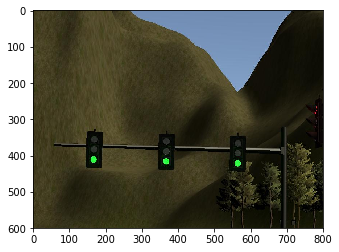

In [20]:
desired_test_index = 100

# Load Image
test_img = loadImage(paths[desired_test_index])
plt.imshow(test_img)

# Run Classification
ohe_index = sess.run(tf.argmax(output, 1), {images: [test_img], keepprob: 1.0})[0]

# Print Information
print("Network guessed: {}".format(label_ohe_map_reversed[ohe_index]))
print("Actual label: {}".format(img_labels[desired_test_index]))
if label_ohe_map_reversed[ohe_index] == img_labels[desired_test_index]:
    print("Correct!")
else:
    print("INCORRECT")

Network guessed: Red


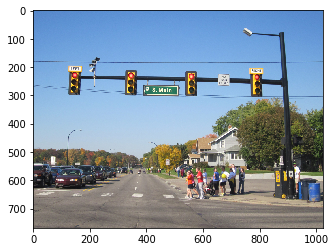

In [16]:
test_img = loadImage('./TL.jpg')
plt.imshow(test_img)

# Run Classification
ohe_index = sess.run(tf.argmax(output, 1), {images: [test_img], keepprob: 1.0})[0]

# Print Information
print("Network guessed: {}".format(label_ohe_map_reversed[ohe_index]))